In [460]:
from sklearn.cluster import KMeans
import pandas as pd
from scipy import stats
import numpy as np
import xarray as xr
from astropy.time import Time
import metpy.calc as mp
from metpy.units import units
import matplotlib.dates as mdates

def readTracks(file):
    dfTracks = pd.read_csv(file)
    dfTracks['Date_S'] = dfTracks['Date_S'].astype(str)
    dfTracks['Datetime'] = pd.to_datetime(dfTracks['Date_S'] + ' ' + dfTracks['Time_S'])
    dfTracks = dfTracks.drop(['Date_S','Time_S'], axis=1)
    dfTracks = dfTracks.set_index('Datetime')
    return dfTracks

# Set to 3 for the new version with .6 and pmodified ping count
df1 = readTracks('../data/analysisFiles/TrackRegions1_linear3.csv')
df4 = readTracks('../data/analysisFiles/TrackRegions4_linear3.csv')
dfD1T = pd.concat([df1,df4])
dfD1T['SigBS_mean'] = 10**(dfD1T.TS_mean/10)
df2 = readTracks('../data/analysisFiles/TrackRegions2_linear3.csv')
df5 = readTracks('../data/analysisFiles/TrackRegions5_linear3.csv')
dfD2T = pd.concat([df2,df5])
dfD3T = readTracks('../data/analysisFiles/TrackRegions6_linear3.csv')

def setTrack(df,mooring):
    a = df[['TS_mean','linearSpeed','linearHead','Target_depth_mean','Num_targets','Target_range_mean']]
    cts,binL = np.histogram(a.linearHead,bins=36,range=[0,360])
    binL = binL[:-1]
    a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
    a['mooring'] = mooring
    return a

def fmtAxis(ax):
    maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
    ax.xaxis.set_major_locator(maj_loc)
    min_loc = mdates.MonthLocator()
    ax.xaxis.set_minor_locator(min_loc)
    zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
    maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
    ax.xaxis.set_major_formatter(maj_fmt)
    
a = setTrack(dfD1T,1)
b = setTrack(dfD2T,2)
c = setTrack(dfD3T,3)

<ipython-input-460-d4f92c339a30>:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['rotateHead'] = a.linearHead-(binL[cts == cts.max()].mean()+10)
<ipython-input-460-d4f92c339a30>:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a['mooring'] = mooring


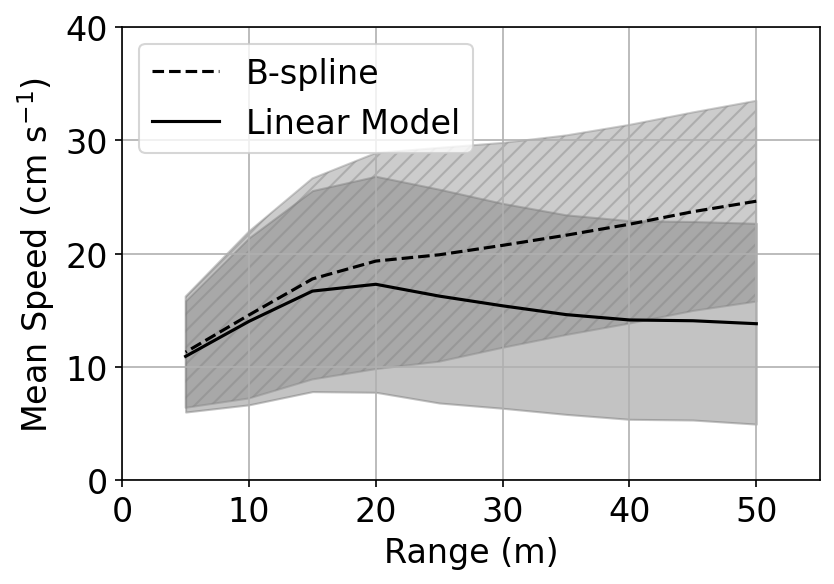

In [346]:
import matplotlib.pyplot as plt
from scipy.stats import sem
allT = pd.concat([dfD1T,dfD2T,dfD3T])
#allT = dfD1T
r = 5

spDir,spLin,spSmooth,spLinSD,spSmoothSD = [],[],[],[],[]
for d in np.arange(0,50,r):
    spDir.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].directSpeed.mean()*100)
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed.mean()*100)
    spLinSD.append(np.std(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100))
    spSmoothSD.append(np.std(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100))
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed.mean()*100)
    
error = .2
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0,50,r),spSmooth,'--k')
plt.plot(np.arange(0,50,r),spLin,'-k')
plt.fill_between(np.arange(0,50,r),np.array(spLin)-np.array(spLinSD),np.array(spLin)+np.array(spLinSD),color='dimgrey',alpha=0.4)
plt.fill_between(np.arange(0,50,r),np.array(spSmooth)-np.array(spSmoothSD),np.array(spSmooth)+np.array(spSmoothSD),color='grey',alpha=0.4,hatch='///')
plt.axis([-5,50,0,40])
plt.gca().invert_xaxis()
plt.xticks(np.arange(0,51,10))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,-1,-10)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
plt.legend(['B-spline','Linear Model'],loc='upper left')
plt.grid()

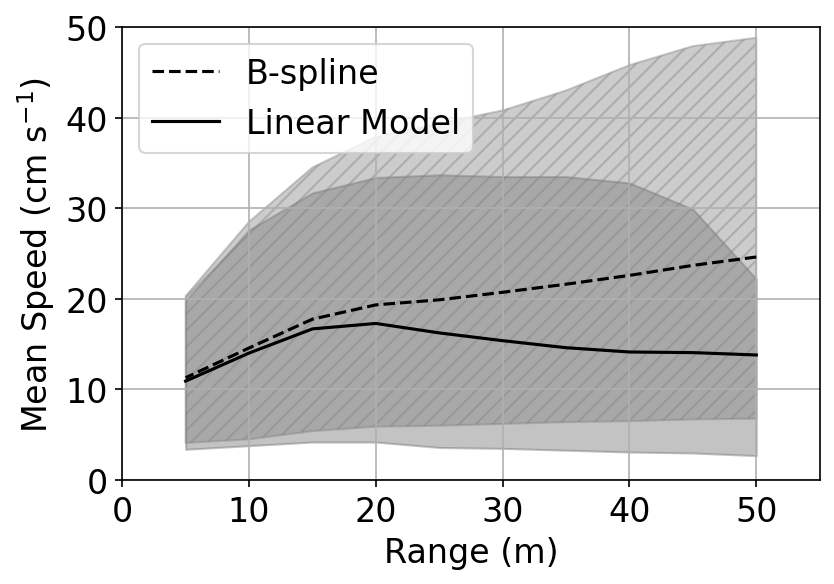

In [348]:
import matplotlib.pyplot as plt
from scipy.stats import sem
allT = pd.concat([dfD1T,dfD2T,dfD3T])
#allT = dfD1T
r = 5

spLin,spSmooth,spLinH,spLinL, spSmoothH,spSmoothL = [],[],[],[],[],[]
for d in np.arange(0,50,r):
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed.mean()*100)
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed.mean()*100)
    spLinH.append(np.percentile(allT[(allT.Target_depth_mean >= d)&(allT.Target_range_mean < d+r)].linearSpeed*100,[95])[0])
    spLinL.append(np.percentile(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100,[5])[0])
    spSmoothH.append(np.percentile(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed*100,[95])[0])
    spSmoothL.append(np.percentile(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed*100,[5])[0])
    
    
error = .2
fig = plt.figure(dpi=150)


plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0,50,r),spSmooth,'--k')
plt.plot(np.arange(0,50,r),spLin,'-k')


plt.fill_between(np.arange(0,50,r),spLinH,spLinL,color='dimgrey',alpha=0.4)
plt.fill_between(np.arange(0,50,r),spSmoothH,spSmoothL,color='grey',alpha=0.4,hatch='///')

plt.axis([-5,50,0,50])
plt.gca().invert_xaxis()
plt.xticks(np.arange(0,51,10))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,-1,-10)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
plt.legend(['B-spline','Linear Model'],loc='upper left')
plt.grid()



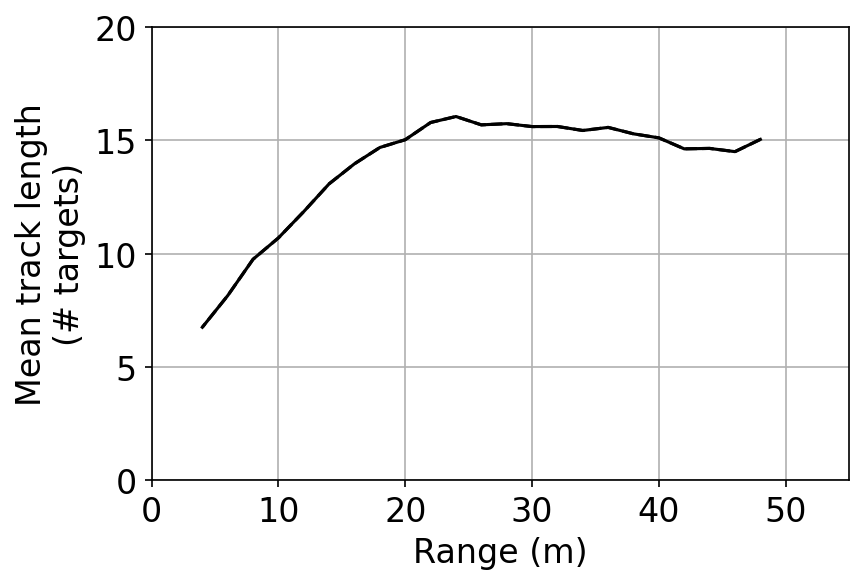

In [154]:
import matplotlib.pyplot as plt
allT = pd.concat([dfD1T,dfD2T,dfD3T])
#allT = dfD1T
r = 2

spDir,spLin,spSmooth,spLinSD,spSmoothSD = [],[],[],[],[]
for d in np.arange(0,50,r):
    spDir.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].Num_targets.mean())
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].Num_targets.mean())
    spLinSD.append(np.std(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].Num_targets))
    spSmoothSD.append(np.std(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].Num_targets))
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].Num_targets.mean())
    
error = .2
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})
plt.plot(np.arange(0,50,r),spSmooth,'--k')
plt.plot(np.arange(0,50,r),spLin,'-k')
#plt.fill_between(np.arange(0,50,r),np.array(spLin)-np.array(spLinSD),np.array(spLin)+np.array(spLinSD),color='grey',alpha=0.4)
#plt.fill_between(np.arange(0,50,r),np.array(spSmooth)-np.array(spSmoothSD),np.array(spSmooth)+np.array(spSmoothSD),color='blue',alpha=0.4)
plt.axis([-5,50,0,20])
plt.gca().invert_xaxis()
plt.xticks(np.arange(0,51,10))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,-1,-10)])
plt.xlabel('Range (m)')
plt.ylabel('Mean track length\n(# targets)')
#plt.legend(['B-spline','Linear Model'],loc='upper left')
plt.grid()

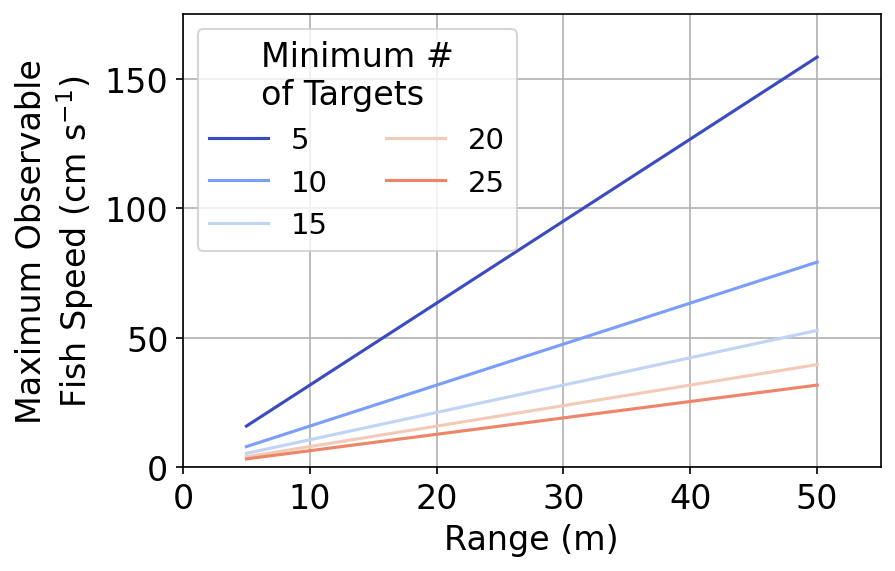

In [344]:
# how big is the beam?
fig = plt.figure(dpi=150)
N = len(np.arange(5,31,5))
cmap = plt.cm.coolwarm
ct=0
rcParams['axes.prop_cycle'] = cycler(color=cmap(np.linspace(0, 1, N)))
bw = [2*(x*np.tan(np.radians(9))) for x in np.arange(5,51,5)]
for nT in [5,10,15,20,25]:
    sp = [d/nT/2 for d in bw]
    plt.plot(np.arange(5,51,r),[100*s for s in sp],color=cmap(np.linspace(0, 1, N))[ct])
    #plt.text(55,44-(ct*10), '>='+str(np.arange(5,31,5)[ct]), color=cmap(np.linspace(0, 1, N))[ct],fontsize=12)
    ct+=1
plt.axis([0,55,0,175])
plt.xlabel('Range (m)')
plt.ylabel('Maximum Observable\nFish Speed (cm s$^{-1}$)')
plt.grid()
plt.legend(['5','10','15','20' ,'25'],title='Minimum #\nof Targets',fontsize=14,ncol=2)
#plt.text(-6,50,'N$_{Targets}$',fontsize=12)

In [ ]:
import matplotlib.pyplot as plt
allT = pd.concat([dfD1T,dfD2T,dfD3T])
r = 5

spLinLong,spLin,spSmooth = [],[],[]
for d in np.arange(0,50,r):
    spLinLong.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)&(allT.Num_targets >=10)].linearSpeed*100)
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100)
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed*100)
    
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})

box=plt.boxplot(spLin,positions =np.arange(5,51,r),whis=[5,95],showfliers=True)
col='orange'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

box=plt.boxplot(spSmooth,positions =np.arange(5,51,r)+1,whis=[5,95],showfliers=True)
col='blue'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

box=plt.boxplot(spLinLong,positions =np.arange(5,51,r)-1,whis=[5,95],showfliers=True)
col='red'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

plt.axis([0,52,0,100])
plt.gca().invert_xaxis()
plt.xticks(np.arange(5,51,5))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,4,-5)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
#plt.legend(['B-spline','Linear Model','Linear Model (>=15 Targets)'],fontsize=10)
plt.grid()

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='red', lw=4)]


plt.legend(custom_lines, ['B-spline', 'Linear', 'Linear (>=10 Targets)'],fontsize=10)

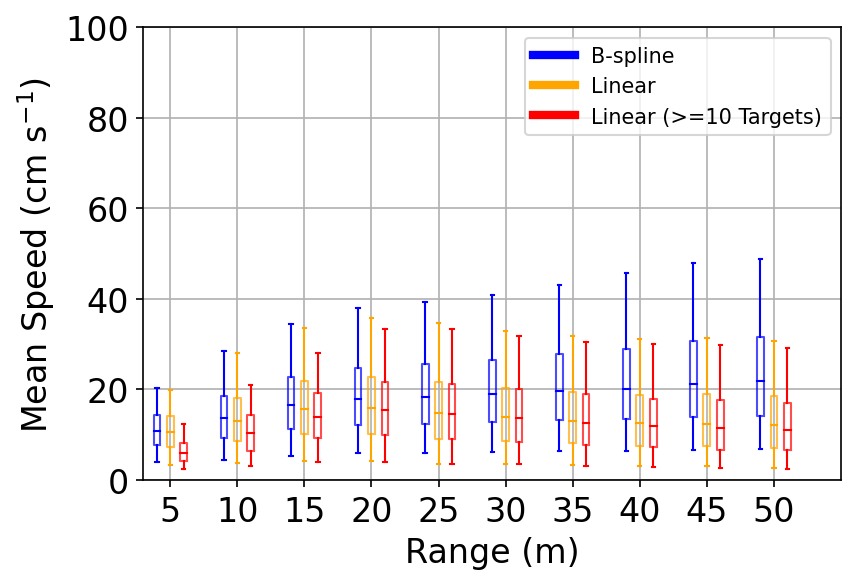

In [198]:
import matplotlib.pyplot as plt
allT = pd.concat([dfD1T,dfD2T,dfD3T])
r = 5

spLinLong,spLin,spSmooth = [],[],[]
for d in np.arange(0,50,r):
    spLinLong.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)&(allT.Num_targets >=10)].linearSpeed*100)
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100)
    spSmooth.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].smoothedSpeed*100)
    
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})

box=plt.boxplot(spLin,positions =np.arange(5,51,r),whis=[5,95],showfliers=False)
col='orange'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

box=plt.boxplot(spSmooth,positions =np.arange(5,51,r)+1,whis=[5,95],showfliers=False)
col='blue'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

box=plt.boxplot(spLinLong,positions =np.arange(5,51,r)-1,whis=[5,95],showfliers=False)
col='red'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

plt.axis([0,52,0,100])
plt.gca().invert_xaxis()
plt.xticks(np.arange(5,51,5))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,4,-5)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
#plt.legend(['B-spline','Linear Model','Linear Model (>=15 Targets)'],fontsize=10)
plt.grid()

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='blue', lw=4),
                Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='red', lw=4)]


plt.legend(custom_lines, ['B-spline', 'Linear', 'Linear (>=10 Targets)'],fontsize=10)

In [461]:
files = ['../data/physicalData/PMEL_2017_17ckp11a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp11a_wcp_vel.nc',
    '../data/physicalData/PMEL_2017_17ckp1a_wcp_vel.nc','../data/physicalData/PMEL_2018_18ckp1a_wcp_vel.nc',
    '../data/physicalData/PMEL_2018_18ckp4a_wcp_vel.nc']
m = [1,1,2,2,3]
dt = []
i = 0
for file in files:
    ds = xr.open_dataset(file,decode_times=False)
    times = ds.time.values+ds.time2.values/1000/60/60/24
    t2 = [Time(time,format='jd').iso for time in times]
    ds['time3'] = pd.to_datetime(t2)
    ds = ds.where(ds.v_1206<1000)
    #dt.append(pd.DataFrame({'dt':ds.time3,'v':np.ravel(ds.sel(depth=28).v_1206),'u':np.ravel(ds.sel(depth=28).u_1205),'mooring':m[i]}))
    dt.append(pd.DataFrame({'dt':ds.time3.values,'u':np.concatenate(np.concatenate(ds.u_1205.mean(dim='depth').values,axis=0)),'v':np.concatenate(np.concatenate(ds.v_1206.mean(dim='depth').values,axis=0)),'mooring':m[i]}))
    i +=1
df = pd.concat(dt)
df = df.set_index('dt')

dt = []
for dfT in [a,b,c]:
    vCur = df[df.mooring==dfT.mooring.unique()[0]]
    vCur = vCur.reindex(dfT.index, method='nearest')
    dfN = pd.merge(dfT,vCur,how='inner', left_index=True, right_index=True)
    dfN['currentDir'] = mp.wind_direction(dfN.u.values*units('cm/s'), dfN.v.values*units('cm/s'),convention='to')
    dfN['currentSpeed'] = mp.wind_speed(dfN.u.values*units('cm/s'), dfN.v.values*units('cm/s'))
    dt.append(dfN.drop_duplicates())
dfMerge = pd.concat(dt)
dfMerge['angOffset'] = abs(dfMerge.currentDir-dfMerge.linearHead)
dfMerge['withCur'] = 0 # set all, this will also be for 'milling'
dfMerge.loc[(dfMerge.angOffset <45) | (dfMerge.angOffset >315), 'withCur'] = 1 # with current
dfMerge.loc[(dfMerge.angOffset >135) & (dfMerge.angOffset <225), 'withCur'] = 2 # against current
dfMerge['tsZone'] = 0 # weak scatterers (lower 25%)
dfMerge.loc[(dfMerge.TS_mean >dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]) & (dfMerge.TS_mean <dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]), 'tsZone'] = 1 # 25- 50%
dfMerge.loc[(dfMerge.TS_mean >dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]) & (dfMerge.TS_mean <dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]), 'tsZone'] = 2 # 50-75%
dfMerge.loc[(dfMerge.TS_mean > dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]), 'tsZone'] = 3 # top 25%
dfMerge['speed'] = 0 # slow
dfMerge.loc[(dfMerge.linearSpeed >dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[0]) & (dfMerge.linearSpeed <dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[1]), 'speed'] = 1 # 25- 50%
dfMerge.loc[(dfMerge.linearSpeed >dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[1]) & (dfMerge.linearSpeed <dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[2]), 'speed'] = 2 # 50-75%
dfMerge.loc[(dfMerge.linearSpeed > dfMerge.linearSpeed.quantile([0.25,0.5,0.75]).values[2]), 'speed'] = 3 # top 25%


uTrack,vTrack = [],[]
for index,row in dfMerge.iterrows():
    if row.linearHead <= 180:
        curHead = row.linearHead + 180
    elif row.linearHead > 180:
        curHead = row.linearHead -180
    
    u,v = mp.wind_components(row.linearSpeed*100*units('cm/s'),curHead*units('deg'))
    uTrack.append(u.magnitude)
    vTrack.append(v.magnitude)
dfMerge['u_track'] = uTrack
dfMerge['v_track'] = vTrack

dfMerge['withPrimary'] = 0 # set all, this will also be for 'milling'
dfMerge.loc[abs(dfMerge.rotateHead) <45, 'withPrimary'] = 1 # with current
dfMerge.loc[(dfMerge.rotateHead >135) & (dfMerge.rotateHead <225), 'withPrimary'] = 2 # against current

In [137]:
dfMergedfMerge.u_track-dfMerge.u
v = dfMerge.v_track-dfMerge.v
dfMerge['tSpeedCor'] = mp.wind_speed(u.values*units('cm/s'),v.values*units('cm/s'))

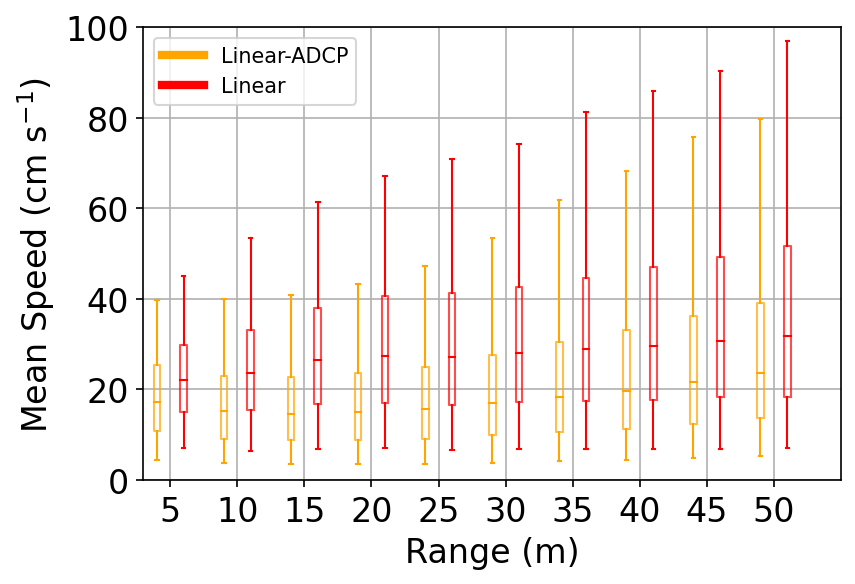

In [171]:
import matplotlib.pyplot as plt
allT = dfMerge#pd.concat([dfD1T,dfD2T,dfD3T])
r = 5

spLin = []
for d in np.arange(0,50,r):
    #spLinLong.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)&(allT.Num_targets >=10)].tSpeedCor)
    spLin.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].tSpeedCor)
    
    
allT = pd.concat([dfD1T,dfD2T,dfD3T])
r = 5

spLinO = []
for d in np.arange(0,50,r):
    spLinO.append(allT[(allT.Target_depth_mean >= d)&(allT.Target_depth_mean < d+r)].linearSpeed*100)
    
fig = plt.figure(dpi=150)
plt.rcParams.update({'font.size': 16})

box=plt.boxplot(spLin,positions =np.arange(5,51,r)+1,whis=[5,95],showfliers=False)
col='orange'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)

box=plt.boxplot(spLinO,positions =np.arange(5,51,r)-1,whis=[5,95],showfliers=False)
col='red'
for item in ['whiskers','caps']:
    plt.setp(box[item], color=col)
for item in ['medians','boxes']:
    plt.setp(box[item], color=col)
plt.setp(box["fliers"], markeredgecolor=col)
plt.setp(box["boxes"], color=col,alpha=0.7)


plt.axis([0,52,0,100])
plt.gca().invert_xaxis()
plt.xticks(np.arange(5,51,5))
plt.gca().set_xticklabels([str(a) for a in np.arange(50,4,-5)])
plt.xlabel('Range (m)')
plt.ylabel('Mean Speed (cm s$^{-1}$)')
#plt.legend(['B-spline','Linear Model','Linear Model (>=15 Targets)'],fontsize=10)
plt.grid()

from matplotlib.lines import Line2D
custom_lines = [Line2D([0], [0], color='orange', lw=4),
                Line2D([0], [0], color='red', lw=4)]


plt.legend(custom_lines, ['Linear-ADCP', 'Linear'],fontsize=10)

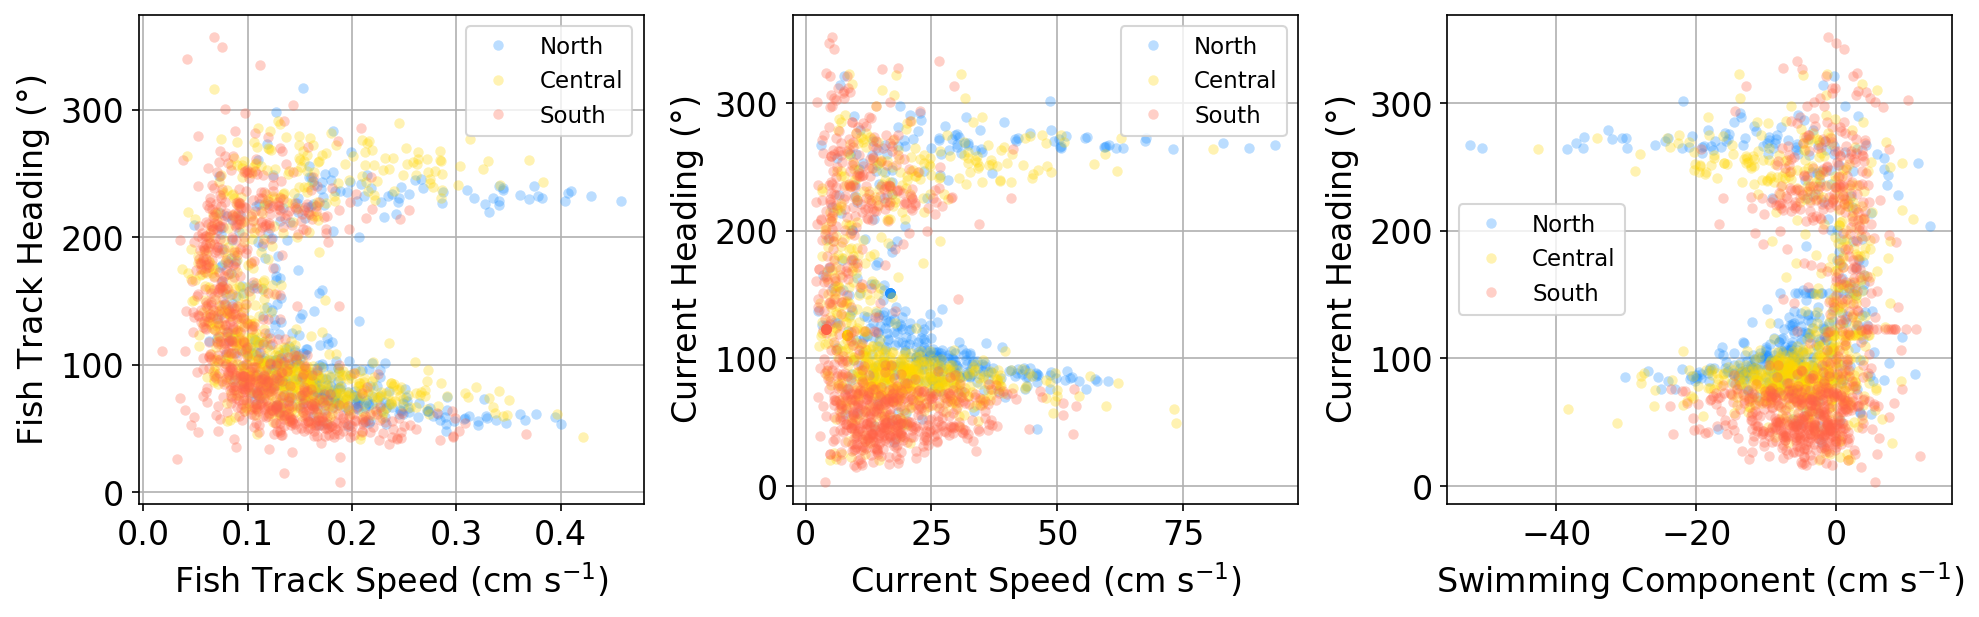

In [597]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)
df = dfMerge[dfMerge.mooring_x==3]
ax1.plot(df.resample('1D').mean().linearSpeed,df.resample('1D').mean().linearHead,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax1.plot(df.resample('1D').mean().linearSpeed,df.resample('1D').mean().linearHead,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax1.plot(df.resample('1D').mean().linearSpeed,df.resample('1D').mean().linearHead,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
#ax1.plot([0,360],[0,360],'--',color='grey')
ax1.set_xlabel('Fish Track Speed (cm s$^{-1}$)')
ax1.set_ylabel('Fish Track Heading ($\degree$)')
#ax1.text(180,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir)[0][1]**2,2)))
#ax1.axis([0,360,0,360])
#ax1.set_xticks([0,90,180,270])
#ax1.set_yticks([0,90,180,270])
ax1.legend(['North','Central','South','1:1'],fontsize=11)
ax1.grid()

df = dfMerge[dfMerge.mooring_x==3]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().currentDir,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().currentDir,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().currentDir,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
#ax1.plot([0,360],[0,360],'--',color='grey')
ax2.set_xlabel('Current Speed (cm s$^{-1}$)')
ax2.set_ylabel('Current Heading ($\degree$)')
#ax1.text(180,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir)[0][1]**2,2)))
#ax1.axis([0,360,0,360])
#ax1.set_xticks([0,90,180,270])
#ax1.set_yticks([0,90,180,270])
ax2.legend(['North','Central','South','1:1'],fontsize=11)
ax2.grid()

df = dfMerge[dfMerge.mooring_x==3]
ax3.plot((df.resample('1D').mean().linearSpeed*100)-df.resample('1D').mean().currentSpeed,df.resample('1D').mean().currentDir,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax3.plot((df.resample('1D').mean().linearSpeed*100)-df.resample('1D').mean().currentSpeed,df.resample('1D').mean().currentDir,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax3.plot((df.resample('1D').mean().linearSpeed*100)-df.resample('1D').mean().currentSpeed,df.resample('1D').mean().currentDir,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
#ax1.plot([0,360],[0,360],'--',color='grey')
ax3.set_xlabel('Swimming Component (cm s$^{-1}$)')
ax3.set_ylabel('Current Heading ($\degree$)')
#ax1.text(180,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir)[0][1]**2,2)))
#ax1.axis([0,360,0,360])
#ax1.set_xticks([0,90,180,270])
#ax1.set_yticks([0,90,180,270])
ax3.legend(['North','Central','South','1:1'],fontsize=11)
ax3.grid()


In [603]:
all[all.linearHead<100].linearSpeed.mean()

0.14263395697816997

5.058489944457213 -0.5475674965305874 [2.14548069e-289 0.00000000e+000] 0.5592288706407378
15.838444032453628
31.676888064907256


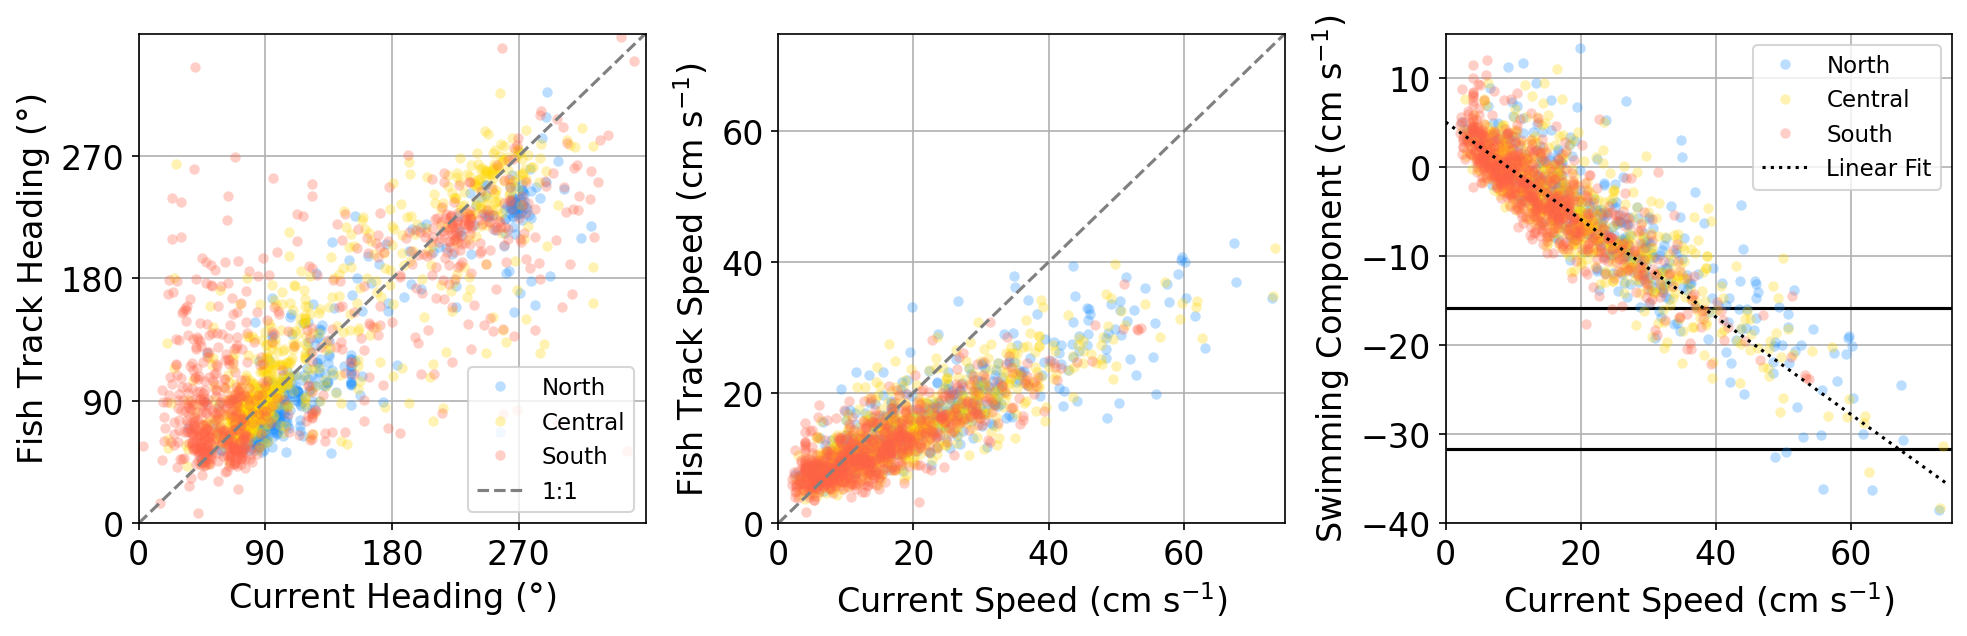

In [606]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)
df = dfMerge[dfMerge.mooring_x==3]
ax1.plot(df.resample('1D').mean().currentDir,df.resample('1D').mean().linearHead,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax1.plot(df.resample('1D').mean().currentDir,df.resample('1D').mean().linearHead,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax1.plot(df.resample('1D').mean().currentDir,df.resample('1D').mean().linearHead,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax1.plot([0,360],[0,360],'--',color='grey')
ax1.set_xlabel('Current Heading ($\degree$)')
ax1.set_ylabel('Fish Track Heading ($\degree$)')
#ax1.text(180,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearHead,dfMerge.resample('1D').mean().currentDir)[0][1]**2,2)))
ax1.axis([0,360,0,360])
ax1.set_xticks([0,90,180,270])
ax1.set_yticks([0,90,180,270])
ax1.legend(['North','Central','South','1:1'],fontsize=11, loc='lower right')
ax1.grid()

df = dfMerge[dfMerge.mooring_x==3]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
ax2.plot([0,75],[0,75],'--',color='grey')
#ax2.plot([10,90],[0,80],'--y')
ax2.set_ylabel('Fish Track Speed (cm s$^{-1}$)')
ax2.set_xlabel('Current Speed (cm s$^{-1}$)')
ax2.set_xticks([0,20,40,60])
ax2.axis([0,75,0,75])
#ax2.text(37,0, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().linearSpeed*100,dfMerge.resample('1D').mean().currentSpeed)[0][1]**2,2)))
ax2.grid()

import statsmodels.api as sm
def olsFit(x,y): # run the statsmodel OLS fit on any x/y vectors
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    # return the intercept, m, and pval
    return model.params[0], model.params[1], model.pvalues, model.rsquared
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]

df = dfMerge[dfMerge.mooring_x==3]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
print(b,m,p,r**2)
ax3.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax3.set_ylabel('Swimming Component (cm s$^{-1}$)')
ax3.set_xlabel('Current Speed (cm s$^{-1}$)')
ax3.set_xticks([0,20,40,60])
ax3.axis([0,75,-40,15])
ax3.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax3.grid()

bw = [2*(x*np.tan(np.radians(9))) for x in np.arange(5,51,5)]
sp = [d/5/2 for d in bw]
plt.hlines(-[s*100 for s in sp][0],0,75,'k')
plt.hlines(-[s*100 for s in sp][1],0,75,'k')
print([s*100 for s in sp][0])
print([s*100 for s in sp][1])

In [565]:
from scipy.stats import pearsonr
print(pearsonr(all.currentDir,all.linearHead)[0]**2)
print(pearsonr(all.currentSpeed,all.linearSpeed*100)[0]**2)

0.581918678002179
0.6693626956617882


In [579]:
print(len(dfMerge[dfMerge.mooring_x==1]))
print(len(dfMerge[dfMerge.mooring_x==2]))
print(len(dfMerge[dfMerge.mooring_x==3]))

63674
83024
40317


In [570]:
print(dfMerge.linearSpeed.mean())
print(dfMerge.linearSpeed.std())

0.1560116086944924
0.09018728331312663


In [ ]:
dfMerge2 = dfMerge
dfMerge3 = dfMerge
dfMerge = dfMerge2[dfMerge2.Target_range_mean > 5]
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)

import statsmodels.api as sm
def olsFit(x,y): # run the statsmodel OLS fit on any x/y vectors
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    # return the intercept, m, and pval
    return model.params[0], model.params[1], model.pvalues, model.rsquared

dfMerge = dfMerge2[dfMerge2.Target_range_mean > 5]

all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax1.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax1.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax1.set_xlabel('Current Speed (cm s$^{-1}$)')
ax1.set_xticks([0,20,40,60])
ax1.axis([0,75,-40,15])
ax1.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax1.grid()
ax1.set_title('Min range: '+str(np.round(dfMerge.Target_range_mean.min())))


dfMerge = dfMerge2[dfMerge2.Target_range_mean > 15]
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax2.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax2.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax2.set_xlabel('Current Speed (cm s$^{-1}$)')
ax2.set_xticks([0,20,40,60])
ax2.axis([0,75,-40,15])
ax2.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax2.grid()
ax2.set_title('Min range: '+str(np.round(dfMerge.Target_range_mean.min())))


dfMerge = dfMerge2[dfMerge2.Target_range_mean > 25]
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax3.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax3.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax3.set_xlabel('Current Speed (cm s$^{-1}$)')
ax3.set_xticks([0,20,40,60])
ax3.axis([0,75,-40,15])
ax3.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax3.grid()
ax3.set_title('Min range: '+str(np.round(dfMerge.Target_range_mean.min())))

bw = [2*(x*np.tan(np.radians(9))) for x in np.arange(5,51,5)]
sp = [d/5/2 for d in bw]
#plt.hlines(-[s*100 for s in sp][0],0,75,'k')
#plt.hlines(-[s*100 for s in sp][1],0,75,'k')
print([s*100 for s in sp][0])
print([s*100 for s in sp][1])

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)

import statsmodels.api as sm
def olsFit(x,y): # run the statsmodel OLS fit on any x/y vectors
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    # return the intercept, m, and pval
    return model.params[0], model.params[1], model.pvalues, model.rsquared

dfMerge = dfMerge2[dfMerge2.Num_targets >= 5]

all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax1.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax1.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax1.set_xlabel('Current Speed (cm s$^{-1}$)')
ax1.set_xticks([0,20,40,60])
ax1.axis([0,75,-40,15])
ax1.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax1.grid()
ax1.set_title('Min # Targets: '+str(np.round(dfMerge.Num_targets.min())))


dfMerge = dfMerge2[dfMerge2.Num_targets >= 15]
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax2.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax2.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax2.set_xlabel('Current Speed (cm s$^{-1}$)')
ax2.set_xticks([0,20,40,60])
ax2.axis([0,75,-40,15])
ax2.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax2.grid()
ax2.set_title('Min # Targets: '+str(np.round(dfMerge.Num_targets.min())))


dfMerge = dfMerge2[dfMerge2.Num_targets >= 25]
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax3.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax3.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax3.set_xlabel('Current Speed (cm s$^{-1}$)')
ax3.set_xticks([0,20,40,60])
ax3.axis([0,75,-40,15])
ax3.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax3.grid()
ax3.set_title('Min # Targets: '+str(np.round(dfMerge.Num_targets.min())))

bw = [2*(x*np.tan(np.radians(9))) for x in np.arange(5,51,5)]
sp = [d/5/2 for d in bw]
#plt.hlines(-[s*100 for s in sp][0],0,75,'k')
#plt.hlines(-[s*100 for s in sp][1],0,75,'k')
print([s*100 for s in sp][0])
print([s*100 for s in sp][1])

In [ ]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2,ax3) = plt.subplots(ncols=3, constrained_layout=True,figsize = (13,4),dpi=150)

import statsmodels.api as sm
def olsFit(x,y): # run the statsmodel OLS fit on any x/y vectors
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    # return the intercept, m, and pval
    return model.params[0], model.params[1], model.pvalues, model.rsquared

dfMerge = dfMerge2[(dfMerge2.currentDir <135)|(dfMerge2.currentDir >315)]

all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax1.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax1.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax1.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax1.set_xlabel('Current Speed (cm s$^{-1}$)')
ax1.set_xticks([0,20,40,60])
ax1.axis([0,75,-40,15])
ax1.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax1.grid()
ax1.set_title('Current Dir 315-135')


dfMerge = dfMerge2[(dfMerge2.currentDir >135)&(dfMerge2.currentDir <315)]
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax2.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax2.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax2.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax2.set_xlabel('Current Speed (cm s$^{-1}$)')
ax2.set_xticks([0,20,40,60])
ax2.axis([0,75,-40,15])
ax2.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax2.grid()
ax2.set_title('Current Dir 135-315')


dfMerge = dfMerge2
all = pd.concat([dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean(),dfMerge[dfMerge.mooring_x==1].resample('1D').mean()])
all = all[(~all.currentSpeed.isnull())|(~all.linearSpeed.isnull())]
df = dfMerge[dfMerge.mooring_x==3]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='dodgerblue',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==2]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='gold',markersize=10,alpha=.3,markeredgecolor='None')
df = dfMerge[dfMerge.mooring_x==1]
ax3.plot(df.resample('1D').mean().currentSpeed,df.resample('1D').mean().linearSpeed*100-df.resample('1D').mean().currentSpeed,'.',color='tomato',markersize=10,alpha=.3,markeredgecolor='None')
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
ax3.plot(np.arange(0,75),b+(np.arange(0,75)*m),':k')
ax3.set_ylabel('Swimming Speed (cm s$^{-1}$)')
ax3.set_xlabel('Current Speed (cm s$^{-1}$)')
ax3.set_xticks([0,20,40,60])
ax3.axis([0,75,-40,15])
ax3.legend(['North','Central','South','Linear Fit'],fontsize=11)#, loc='lower right')
ax3.grid()
ax3.set_title('All Directions')

bw = [2*(x*np.tan(np.radians(9))) for x in np.arange(5,51,5)]
sp = [d/5/2 for d in bw]
#plt.hlines(-[s*100 for s in sp][0],0,75,'k')
#plt.hlines(-[s*100 for s in sp][1],0,75,'k')
print([s*100 for s in sp][0])
print([s*100 for s in sp][1])

In [529]:
ss = (all.linearSpeed.values*100)
len(ss[ss<15.86])/len(ss)

ss = (all.linearSpeed.values*100)-all.currentSpeed.values
len(ss[ss>-15.83])/len(ss)

0.9186602870813397

In [438]:
b,m,p,r = olsFit(all.currentSpeed.values,(all.linearSpeed.values*100)-all.currentSpeed.values)
b,m,p,r**2

(5.66491098943873,
 -0.6053917803083249,
 array([1.35052629e-307, 0.00000000e+000]),
 0.5915437821384228)

In [127]:
from glob import glob
import xarray as xr
uf = glob('../data/physicalData/wind/uwnd*')
vf = glob('../data/physicalData/wind/vwnd*')
dsU = xr.open_mfdataset(uf)
dsV = xr.open_mfdataset(vf)
dsWind = dsU.merge(dsV)
dsWind.sel(lat=70,lon=195)
dfWind =dsWind.sel(lat=70,lon=195).to_dataframe()

<ipython-input-139-09762a8c0c08>:18: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax1.pcolormesh(t,[1,2],np.reshape(wSpeed,(1,len(wSpeed))),cmap=cmocean.cm.balance,vmin=-10, vmax=10)
<ipython-input-139-09762a8c0c08>:35: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  ax2.pcolormesh(t,[1,2],np.reshape(cSpeed,(1,len(cSpeed))),cmap=cmocean.cm.amp,vmin=0, vmax=25)
<ipython-input-139-09762a8c0c08>:36: MatplotlibDeprecationWarning: shading='flat' when X and Y have 

Text(0.5, 0, 'Date')

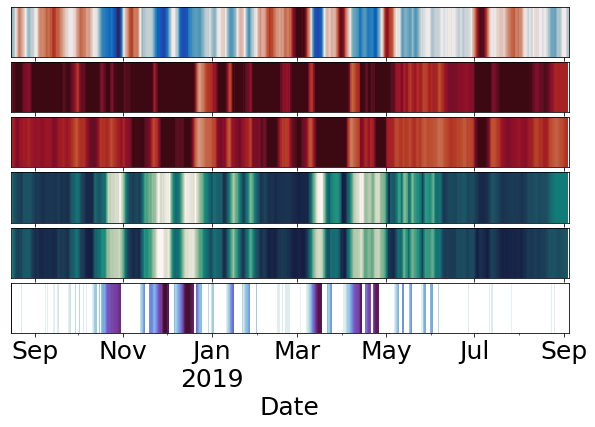

In [139]:
import matplotlib.pyplot as plt
import cmocean

mooring = 3
resample = '7D'
mooringoffset = [50,85,80]
if mooring == 3:
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(10,6))
else:    
    fig, (ax1,ax2,ax3,ax4,ax5,ax6) = plt.subplots(6,1,figsize=(20,6))

dfCur = dfWind
dfCur['windSpeed'] = mp.wind_speed(dfCur.uwnd.values*units('m/s'), dfCur.vwnd.values*units('m/s'))
#wSpeed = dfCur.rolling(resample).mean().vwnd.values
wSpeed = dfCur.rolling(resample).mean().vwnd.values
t = dfCur.rolling(resample).mean().index.values

ax1.pcolormesh(t,[1,2],np.reshape(wSpeed,(1,len(wSpeed))),cmap=cmocean.cm.balance,vmin=-10, vmax=10)

dfCur = dfMerge[dfMerge.mooring_x==mooring]
t = dfCur.rolling(resample).mean().index.values
head = abs(dfCur.rolling(resample).mean().rotateHead.values)
cSpeed = dfCur.rolling(resample).mean().currentSpeed.values
tSpeed = dfCur.rolling(resample).mean().linearSpeed.values*100
cDir = dfCur.rolling(resample).mean().currentDir.values-mooringoffset[mooring-1]
cDir[cDir>180] = cDir[cDir>180]-360
cDir = abs(cDir)

d1 = dfCur[dfCur.withPrimary==2].rolling(resample).count()
d2 = dfCur.rolling(resample).count()
withCur = d1.withPrimary/d2.withPrimary
#withCur = withCur.fillna(0)


ax2.pcolormesh(t,[1,2],np.reshape(cSpeed,(1,len(cSpeed))),cmap=cmocean.cm.amp,vmin=0, vmax=25)
ax3.pcolormesh(t,[1,2],np.reshape(tSpeed,(1,len(tSpeed))),cmap=cmocean.cm.amp,vmin=0, vmax=25)
ax4.pcolormesh(t,[1,2],np.reshape(cDir,(1,len(cDir))),cmap=cmocean.cm.tempo_r,vmin=0, vmax=180)
ax5.pcolormesh(t,[1,2],np.reshape(head,(1,len(head))),cmap=cmocean.cm.tempo_r,vmin=0, vmax=180)
ax6.pcolormesh(withCur.index,[1,2],np.reshape(withCur.values,(1,len(withCur.rolling(resample).mean().values))),cmap=cmocean.cm.dense,vmin=0, vmax=1)
#ax1.text(pd.to_datetime('2017-08-15'),2.1,'Northward Wind Speed')
#ax2.text(pd.to_datetime('2017-08-15'),2.1,'ADCP Speed')
#ax3.text(pd.to_datetime('2017-08-15'),2.1,'Track Speed')
#ax4.text(pd.to_datetime('2017-08-15'),2.1,'ADCP Direction')
#ax5.text(pd.to_datetime('2017-08-15'),2.1,'Track Direction')
#ax6.text(pd.to_datetime('2017-08-15'),2.1,'% tracks S/E')
[a.set_xticklabels(['']) for a in [ax1,ax2,ax3,ax4,ax5]]
[a.set_yticklabels(['']) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
[a.set_yticks([]) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
if mooring == 3:
    [a.set_xlim([t[0],pd.to_datetime('2019-9-4')]) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
else:
    [a.set_xlim([pd.to_datetime('2017-8-4'),pd.to_datetime('2019-9-4')]) for a in [ax1,ax2,ax3,ax4,ax5,ax6]]
plt.subplots_adjust(hspace=0.1)

plt.rcParams.update({'font.size':25})
maj_loc = mdates.MonthLocator(bymonth=np.arange(1,12,2))
ax6.xaxis.set_major_locator(maj_loc)
min_loc = mdates.MonthLocator()
ax6.xaxis.set_minor_locator(min_loc)
zfmts = ['', '%b\n%Y', '%b', '%b-%d', '%H:%M', '%H:%M']
maj_fmt = mdates.ConciseDateFormatter(maj_loc, zero_formats=zfmts, show_offset=False)
ax6.xaxis.set_major_formatter(maj_fmt)
ax6.set_xlabel('Date')

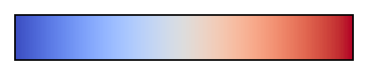

In [176]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import cmocean

fig = plt.figure(figsize=(2.5, 2),dpi=150)
ax1 = fig.add_axes([0.05, 0.80, 0.9, 0.15])
#cmap = cmocean.cm.tempo
#cmap = cmocean.cm.amp
#cmap = cmocean.cm.dense
cmap = mpl.cm.coolwarm
norm = mpl.colors.Normalize(vmin=0, vmax=3)
cb1 = mpl.colorbar.ColorbarBase(ax1, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')
cb1.set_ticks([])

Text(-35, 40, 'R$^{2}$ = 0.72')

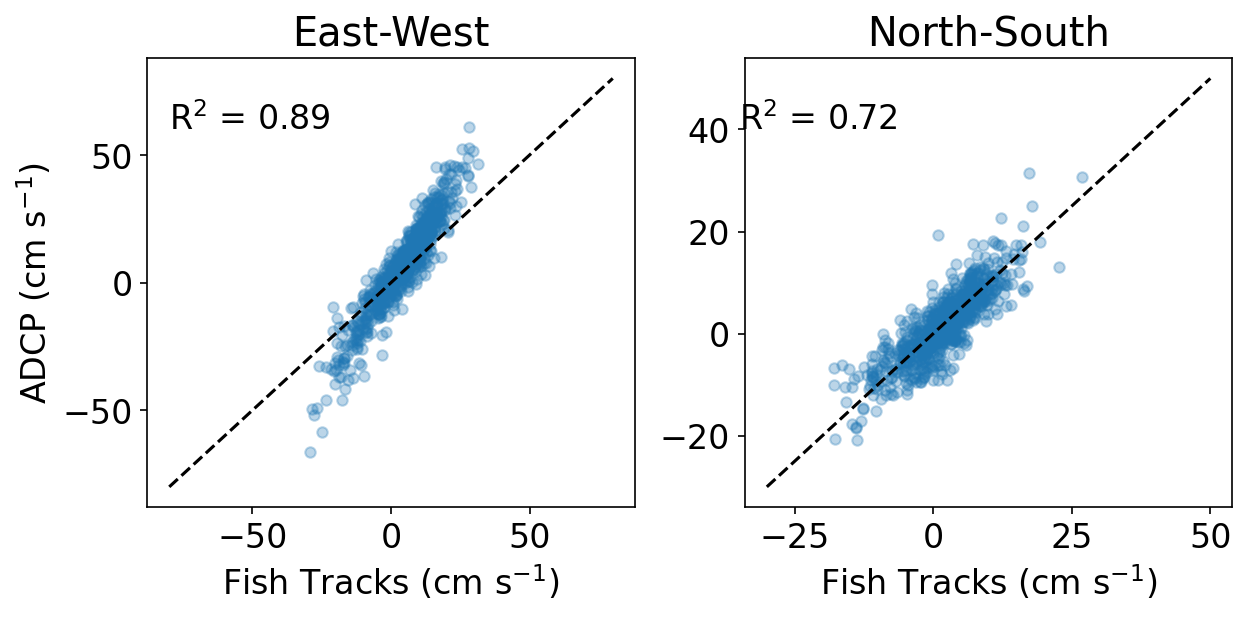

In [177]:
plt.rcParams.update({'font.size': 16})
fig, (ax1, ax2) = plt.subplots(ncols=2, constrained_layout=True,figsize = (8.2,4),dpi=150)
ax1.plot(dfMerge.resample('1D').mean().u_track,dfMerge.resample('1D').mean().u,'.',markersize=10,alpha=.3)
ax1.plot([-80,80],[-80,80],'--k')
ax1.set_title('East-West')
ax1.set_ylabel('ADCP (cm s$^{-1}$)')
ax1.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax1.text(-80,60, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().u_track,dfMerge.resample('1D').mean().u)[0][1]**2,2)))

ax2.plot(dfMerge.resample('1D').mean().v_track,dfMerge.resample('1D').mean().v,'.',markersize=10,alpha=.3)
ax2.plot([-30,50],[-30,50],'--k')
ax2.set_title('North-South')
ax2.set_xlabel('Fish Tracks (cm s$^{-1}$)')
ax2.text(-35,40, 'R$^{2}$ = '+str(np.round(np.corrcoef(dfMerge.resample('1D').mean().v_track,dfMerge.resample('1D').mean().v)[0][1]**2,2)))

array([-58.8248375, -54.85032  , -51.3032015])

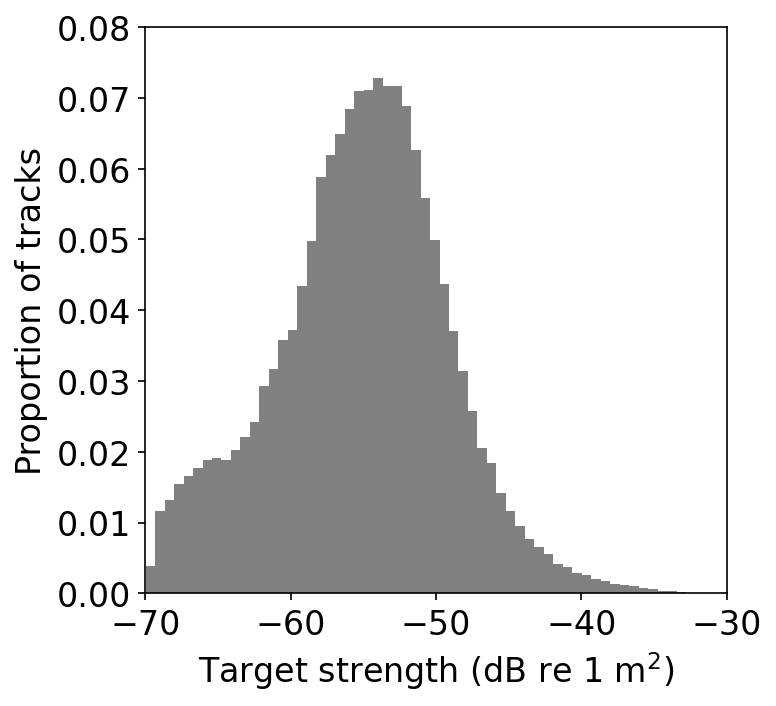

In [377]:
fig = plt.figure(figsize=(5,5),dpi=150)
plt.hist(dfMerge.TS_mean,bins=60,density=True,color='grey');
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')
plt.axis([-70,-30,0,.08])
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Target strength (dB re 1 m$^{2}$)')
plt.ylabel('Proportion of tracks')
dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values

In [400]:
10*np.log10(np.mean(10**(dfMerge[dfMerge.mooring_x==3].TS_mean/10)))

-49.78618941062607

In [402]:
dfMerge.TS_mean.mean()

-55.17487223821668

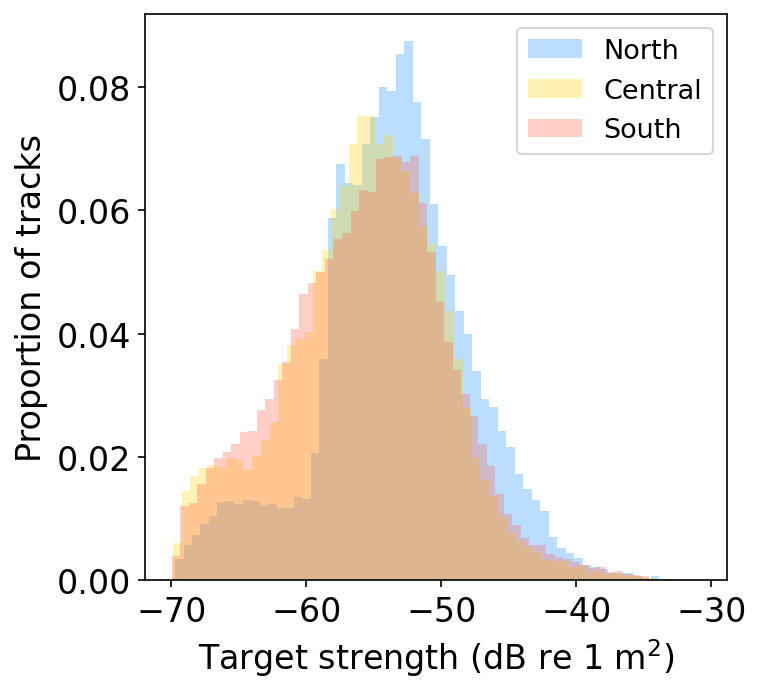

In [391]:
fig = plt.figure(figsize=(5,5),dpi=150)

plt.hist(dfMerge[dfMerge.mooring_x==3].TS_mean,bins=60,density=True,color='dodgerblue',alpha=0.3);
plt.hist(dfMerge[dfMerge.mooring_x==2].TS_mean,bins=60,density=True,color='gold',alpha=0.3);
plt.hist(dfMerge[dfMerge.mooring_x==1].TS_mean,bins=60,density=True,color='tomato',alpha=0.3);
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')
#plt.axis([-70,-30,0,.08])
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Target strength (dB re 1 m$^{2}$)')
plt.ylabel('Proportion of tracks')
plt.legend(['North','Central','South'],fontsize=13)

In [387]:
len(allT[allT.Target_range_mean<=5])/len(allT)

0.06095767719166912

26.87559682651114
10.47522375252484


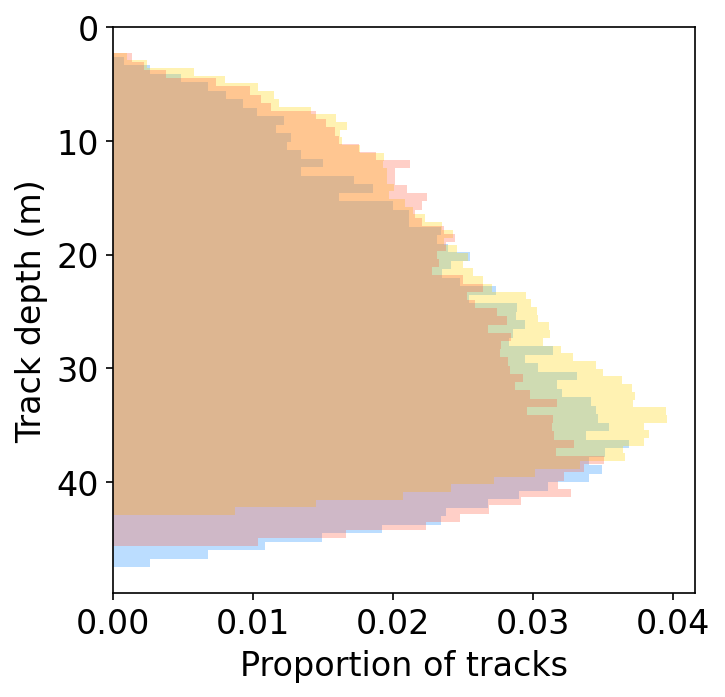

In [389]:
fig = plt.figure(figsize=(5,5),dpi=150)

plt.hist(dfMerge[dfMerge.mooring_x==3].Target_depth_mean,bins=60,density=True,color='dodgerblue',alpha=0.3,orientation='horizontal');
plt.hist(dfMerge[dfMerge.mooring_x==2].Target_depth_mean,bins=60,density=True,color='gold',alpha=0.3,orientation='horizontal');
plt.hist(dfMerge[dfMerge.mooring_x==1].Target_depth_mean,bins=60,density=True,color='tomato',alpha=0.3,orientation='horizontal');
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1],0,.08,'k')
#plt.vlines(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2],0,.08,'k')
#plt.axis([-70,-30,0,.08])
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[0]+.1,0.075, '25%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[1]+.1,0.075, '50%',fontsize=12)
#plt.text(dfMerge.TS_mean.quantile([0.25,0.5,0.75]).values[2]+.1,0.075, '75%',fontsize=12)
plt.xlabel('Proportion of tracks')
plt.ylabel('Track depth (m)')
plt.gca().invert_yaxis()
#plt.legend(['North','Central','South'],fontsize=13)
print(dfMerge.Target_depth_mean.mean())
print(dfMerge.Target_depth_mean.std())

Text(0.5, 0, 'Date')

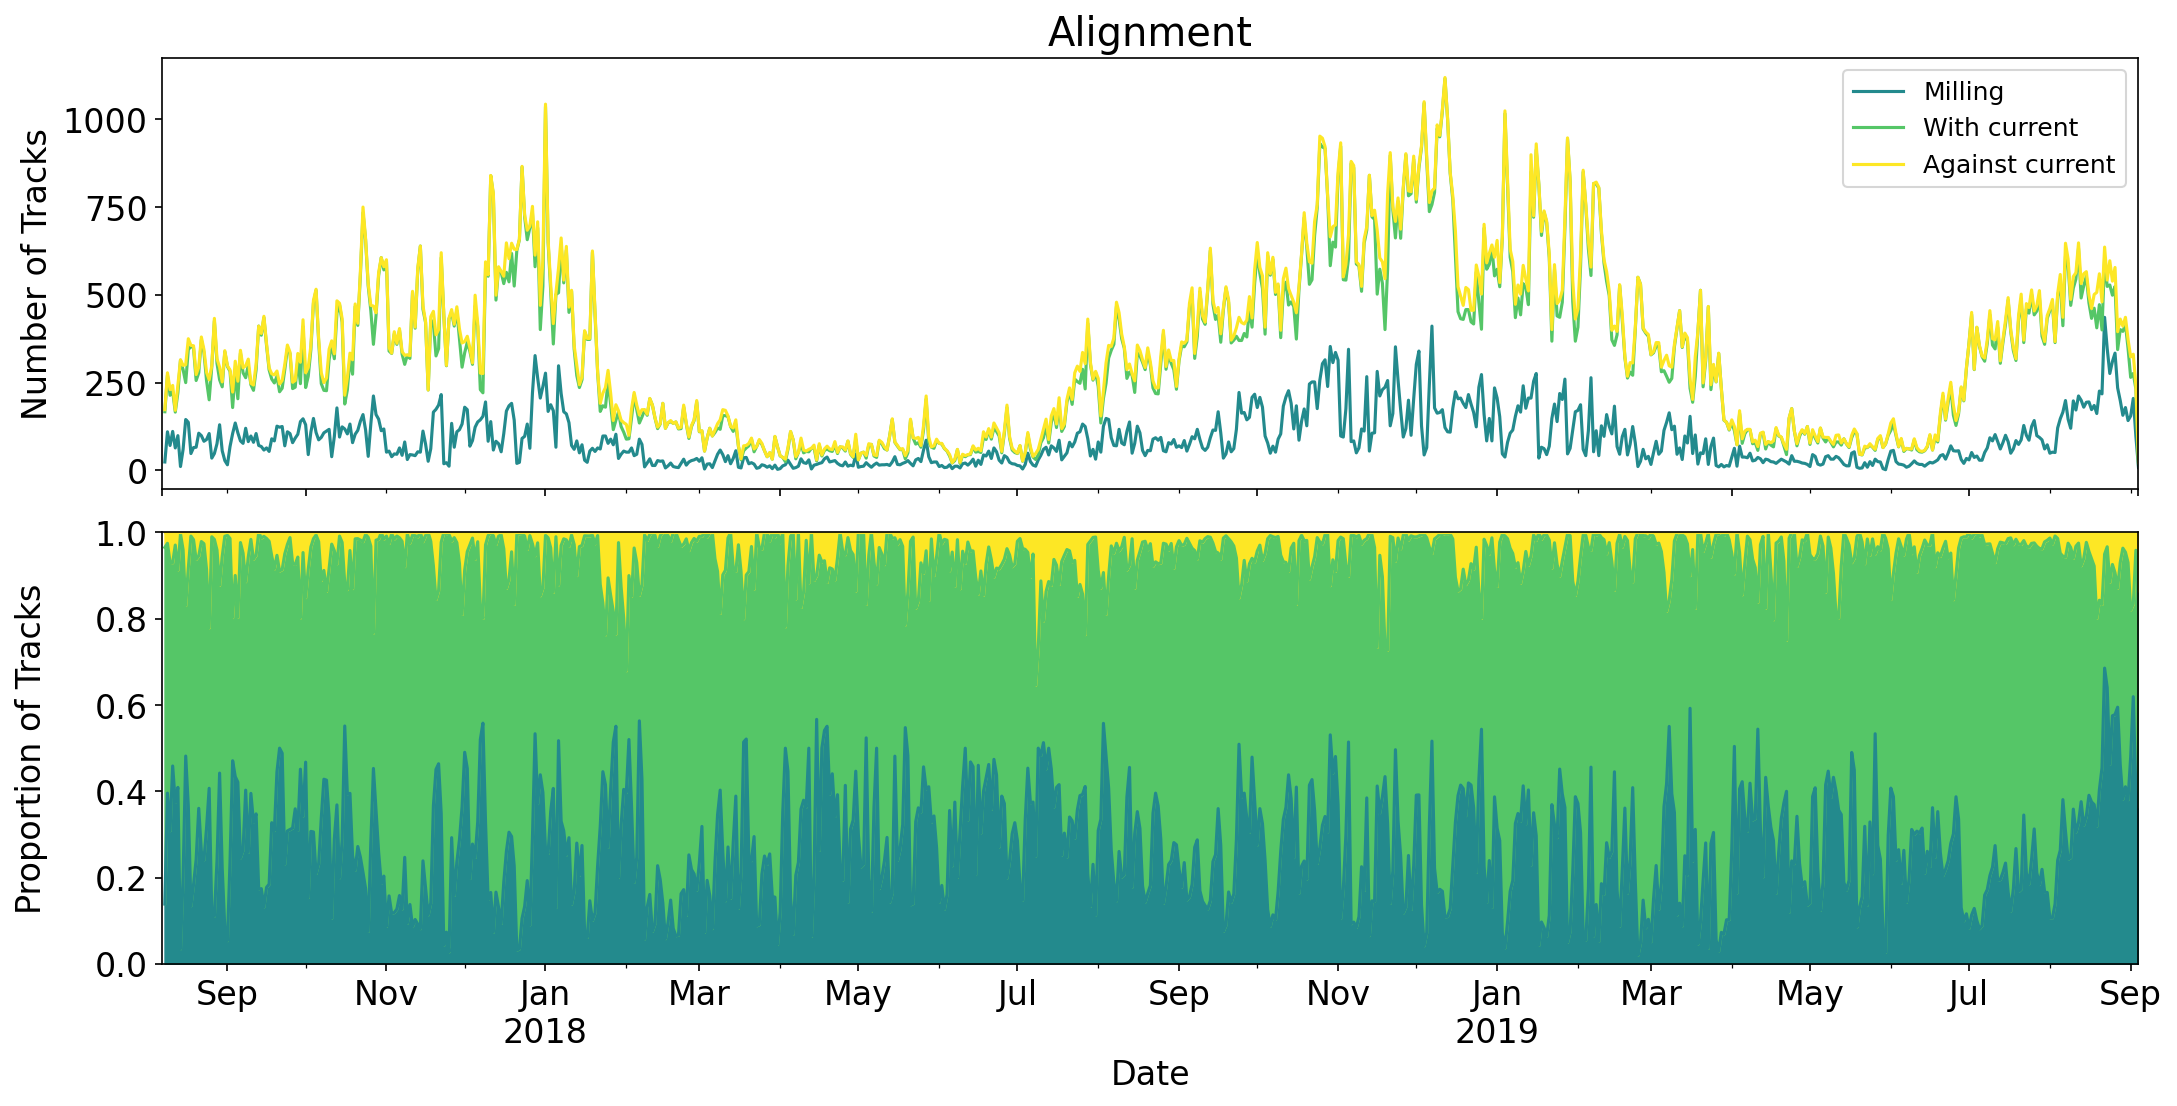

In [92]:
colors = ['#404788FF','#238A8DFF','#55C667FF','#FDE725FF']
resample = '1D'
# WithCur: 0 = milling, 1 = with current, 2 = against current
fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMerge[dfMerge.withCur== 0].resample(resample).count().speed.plot(color=colors[1]) # Milling
dfMerge[(dfMerge.withCur== 0)|(dfMerge.withCur== 1)].resample(resample).count().withCur.plot(color=colors[2]) # milling and with current
dfMerge.resample(resample).count().withCur.plot(color=colors[3])

ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
plt.legend(['Milling','With current','Against current'],fontsize=12)
plt.title('Alignment')
plt.ylabel('Number of Tracks')


ax2 = plt.subplot(212)
hold = 0
ct = 1
for k in [0,1,2]:
    dfCur = dfMerge[dfMerge.withCur==k].resample(resample).count()
    dfCurTot = dfMerge.resample(resample).count()
    d = (dfCur.withCur/dfCurTot.withCur)
    ax2.plot(d+hold,color = colors[ct])
    ax2.fill_between(dfCur.index,d+hold,0+hold,color = colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])

ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

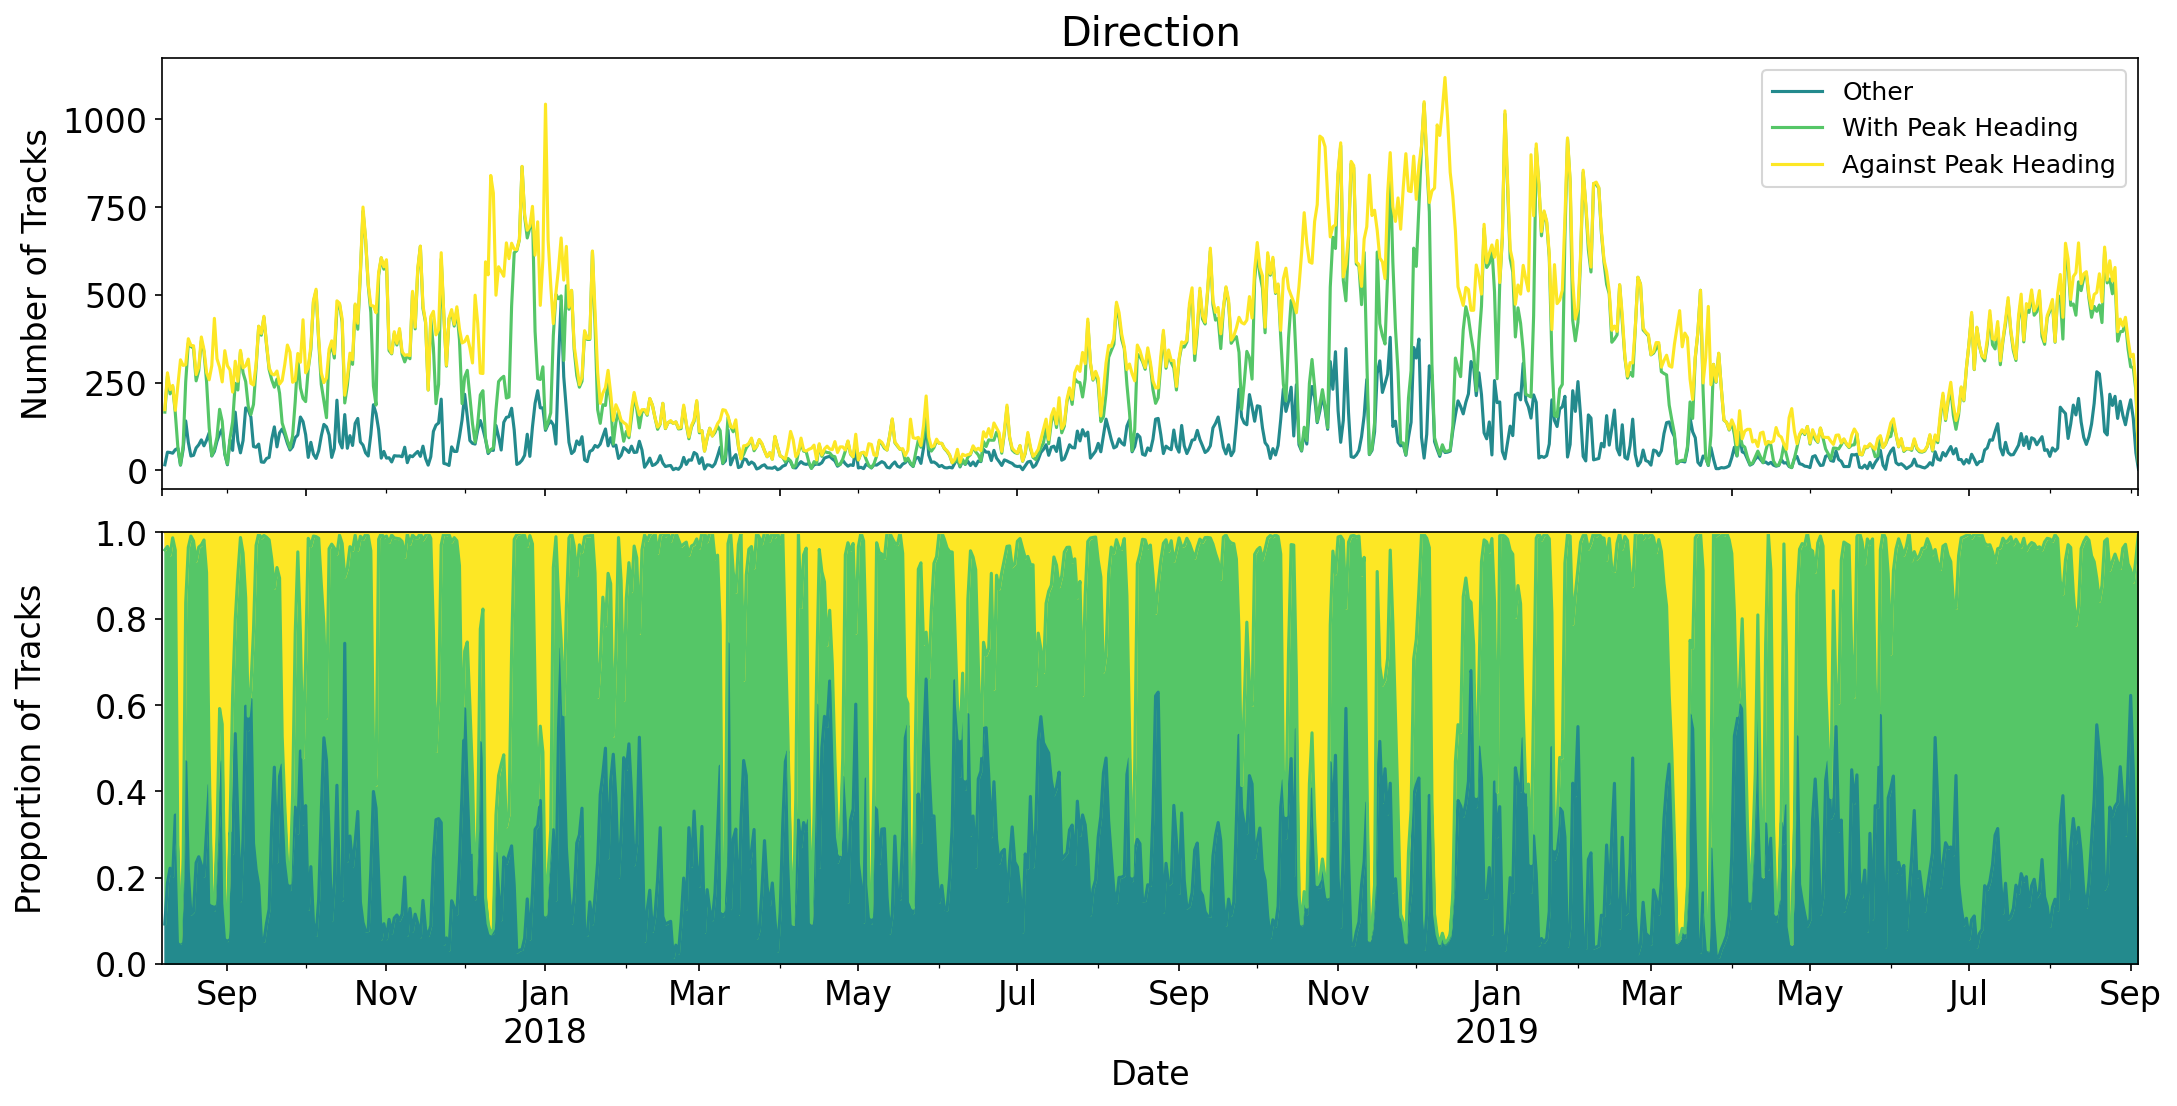

In [99]:
colors = ['#404788FF','#238A8DFF','#55C667FF','#FDE725FF']
resample = '1D'

dfMergeCur = dfMerge#[(dfMerge.tsZone==3)]#|(dfMerge.tsZone==1)]

# WithCur: 0 = milling, 1 = with current, 2 = against current
fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMergeCur[dfMergeCur.withPrimary== 0].resample(resample).count().speed.plot(color=colors[1]) # Milling
dfMergeCur[(dfMergeCur.withPrimary== 0)|(dfMergeCur.withPrimary== 1)].resample(resample).count().withPrimary.plot(color=colors[2]) # milling and with current
dfMergeCur.resample(resample).count().withPrimary.plot(color=colors[3])

ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
plt.legend(['Other','With Peak Heading','Against Peak Heading'],fontsize=12)
plt.title('Direction')
plt.ylabel('Number of Tracks')

ax2 = plt.subplot(212)
hold = 0

ct = 1
for k in [0,1,2]:
    dfCur = dfMergeCur[dfMergeCur.withPrimary==k].resample(resample).count()
    dfCurTot = dfMergeCur.resample(resample).count()
    d = (dfCur.withPrimary/dfCurTot.withPrimary)
    ax2.plot(d+hold,color = colors[ct])
    a = d+hold
    b = 0+hold
    try:
        ax2.fill_between(dfCur.index,a[:len(dfCur.index)],b[:len(dfCur.index)],color = colors[ct])
    except:
        ax2.fill_between(dfCur.index,a[:len(dfCur.index)],b,color = colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])


ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

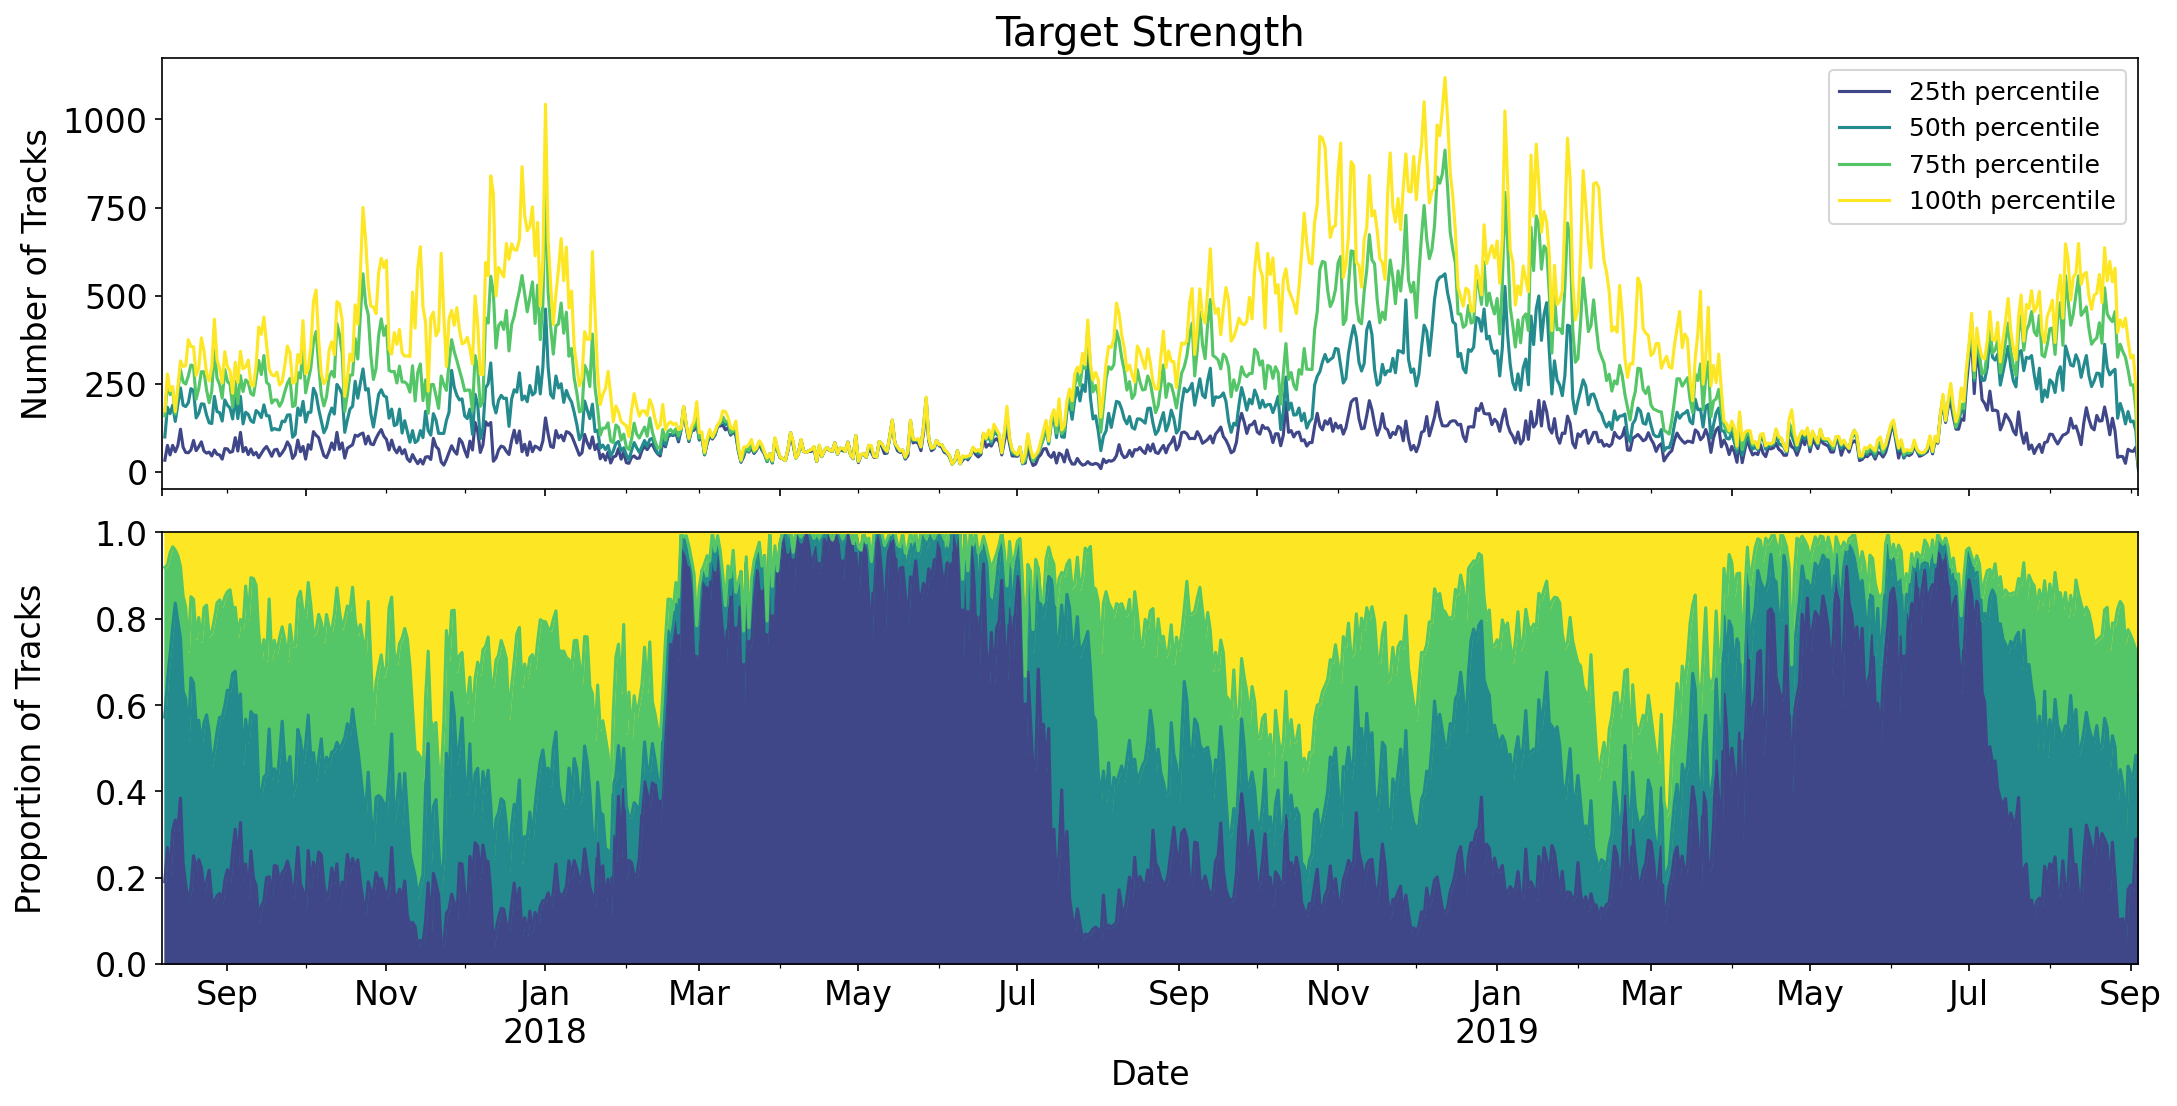

In [95]:
resample = '1D'
colors = ['#404788FF','#238A8DFF','#55C667FF','#FDE725FF']
# tsZone: 0 = 0-25%, 1 = 25-50%, 2 = 50-75%, 3 = 75-100%

fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMerge[dfMerge.tsZone== 0].resample(resample).count().speed.plot(color=colors[0]) # Milling
dfMerge[(dfMerge.tsZone== 0)|(dfMerge.tsZone== 1)].resample(resample).count().tsZone.plot(color=colors[1]) # milling and with current
dfMerge[(dfMerge.tsZone== 0)|(dfMerge.tsZone== 1)|(dfMerge.tsZone== 2)].resample(resample).count().tsZone.plot(color=colors[2]) # milling and with current
dfMerge.resample(resample).count().speed.plot(color=colors[3])
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
plt.legend(['25th percentile','50th percentile','75th percentile','100th percentile'],fontsize=12)
plt.title('Target Strength')
plt.ylabel('Number of Tracks')

ax2 = plt.subplot(212)
hold = 0
ct = 0
for k in [0,1,2,3]:
    dfCur = dfMerge[dfMerge.tsZone==k].resample(resample).count()
    dfCurTot = dfMerge.resample(resample).count()
    d = (dfCur.tsZone/dfCurTot.tsZone)
    ax2.plot(d+hold,color=colors[ct])
    ax2.fill_between(dfCur.index,d+hold,0+hold,color=colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])

ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')

Text(0.5, 0, 'Date')

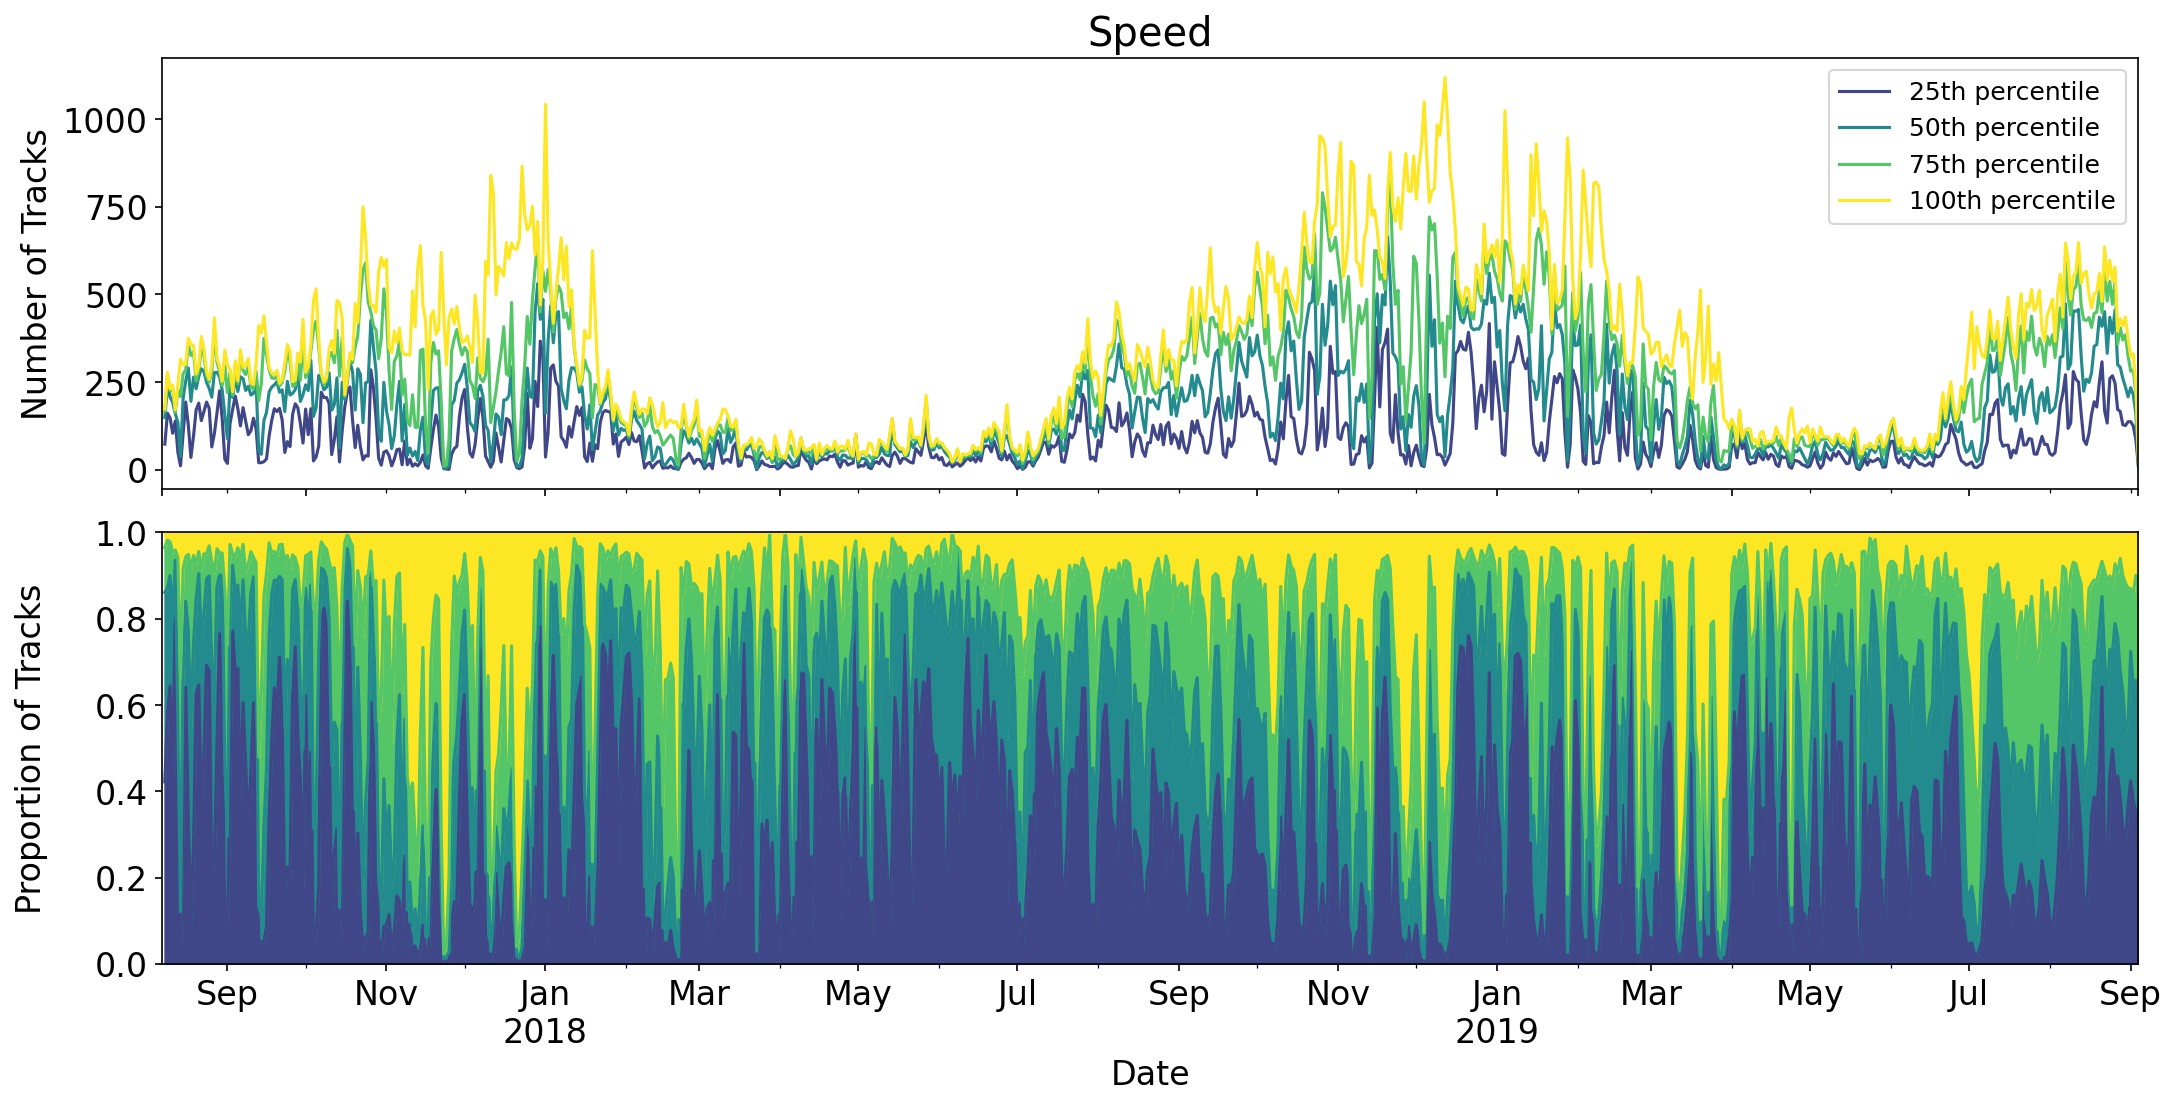

In [96]:
resample = '1D'

# tsZone: 0 = 0-25%, 1 = 25-50%, 2 = 50-75%, 3 = 75-100%

fig = plt.figure(figsize=(17,8),dpi = 150)
ax1 = plt.subplot(211)
dfMerge[dfMerge.speed== 0].resample(resample).count().speed.plot(color=colors[0]) # Milling
dfMerge[(dfMerge.speed== 0)|(dfMerge.speed== 1)].resample(resample).count().tsZone.plot(color=colors[1]) # milling and with current
dfMerge[(dfMerge.speed== 0)|(dfMerge.speed== 1)|(dfMerge.speed== 2)].resample(resample).count().tsZone.plot(color=colors[2]) # milling and with current
dfMerge.resample(resample).count().speed.plot(color=colors[3])
plt.legend(['25th percentile','50th percentile','75th percentile','100th percentile'],fontsize=12)
plt.title('Speed')
plt.ylabel('Number of Tracks')
ax1.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])


ax2 = plt.subplot(212)
hold = 0
ct =0
for k in [0,1,2,3]:
    dfCur = dfMerge[dfMerge.speed==k].resample(resample).count()
    dfCurTot = dfMerge.resample(resample).count()
    d = (dfCur.speed/dfCurTot.speed)
    ax2.plot(d+hold,color=colors[ct])
    ax2.fill_between(dfCur.index,d+hold,0+hold,color=colors[ct])
    hold = d+hold
    ct+=1
plt.ylabel('Proportion of Tracks\n')
ax2.set_xlim([pd.to_datetime('2017-8-7'),pd.to_datetime('2019-9-4')])
ax2.set_ylim([0,1])

ax1.set_xticklabels([])
ax1.set_xlabel('')
fmtAxis(ax2)
plt.subplots_adjust(hspace=0.1)
plt.xlabel('Date')